# **VehicleLateralStability-Py** (Notebook)

---

## Enhancing Lateral Stability using Active Front Steering (AFS)
## **LQR vs Sliding Mode Control (SMC)**


### 0) **Goal**

Build a Python-based simulation and control framework for vehicle lateral stability using:
- Vehicle lateral–yaw dynamics (linear bicycle model)
- Desired yaw-rate generation from a curvature command ρ(t)
- Tracking control using Active Front Steering (AFS) correction:
  - Controller 1: **LQR**
  - Controller 2: **SMC**
- Compare tracking + control effort using plots and metrics.

System structure:
- **Feedforward steering** from curvature (Ackerman approximation)
- **Feedback steering correction** from LQR / SMC
- Simulate under a time-varying curvature profile and interpret results via stability + tracking quality.


### 1) **Modeling Setup (What the states mean)**

We use a standard *linear bicycle model* for lateral dynamics at constant longitudinal speed Vx.

Primary states:
- **Vy** = lateral velocity (m/s)
- **r**  = yaw rate (rad/s)

Input:
- **u = δ** = front steering angle (rad)

Outputs of interest:
- Vy(t), r(t), steering input components (u_ff, u_corr, u_total)


### 2) **Curvature Command and Feedforward Steering**

Road curvature command:
- ρ(t) [1/m] is the commanded curvature profile (piecewise / time-varying)

Feedforward steering (simple geometry):
- L = lf + lr
- **u_ff(t) = L * ρ(t)**

This provides the “baseline steering needed to follow curvature” without feedback stabilization.


### 3) **Desired Yaw Rate (Reference)**

With constant Vx:
- **r_des(t) = Vx * ρ(t)**

We design feedback to ensure yaw dynamics and lateral response track the reference safely and stably.

Define tracking errors:
- e1 = Vy - Vy_des
- e2 = r  - r_des

Typically Vy_des = 0 in the baseline formulation (or a derived signal depending on the chosen reference model).  
We will keep the reference definition consistent throughout the notebook.


### 4) **Plant Dynamics (Linear Bicycle Model Form)**

The linearized continuous-time model around small slip angles:

x = [Vy, r]^T

x_dot = A x + B u

A and B depend on:
- m (mass), Iz (yaw inertia)
- lf, lr (CG distances)
- Cαf, Cαr (front/rear cornering stiffness)
- Vx (longitudinal speed)

We will implement A and B using a fixed parameter set and clearly document it.


### 5) **Controllers**

#### 5.1 LQR (feedback on tracking error)

Design K from the continuous-time algebraic Riccati equation on error dynamics:
- **u_corr = -K * e**
- **u_total = u_ff + u_corr**

Tune Q and R to balance tracking performance vs steering effort.

#### 5.2 SMC (robust, nonlinear switching control)

Choose sliding surface:
- s = e2 + λ e1

Then:
- u_total = u_ff + u_eq + u_sw
- Switching uses a saturation boundary layer to reduce chattering:
  - sat(s/ϕ) instead of pure sign(s)


### 6) **Simulation Procedure** (How we’ll build the notebook)

We build incrementally, validating at every step:

1) Define parameters (m, Iz, lf, lr, Cαf, Cαr, Vx, etc.)
2) Implement curvature profile ρ(t) and feedforward u_ff(t)
3) Implement plant A,B and the continuous-time ODE function
4) Simulate open-loop / feedforward-only (sanity baseline)
5) Add LQR controller and generate plots (Vy, r, steering)
6) Add SMC controller and generate plots (Vy, r, steering)
7) Add metrics (RMS error, settling time, effort ∫u² dt)
8) Save figures into /results later when we convert to modular .py scripts

**Notebook philosophy:**
- Notebook is the “truth lab” (interactive + plots)
- After it works, we refactor into clean src/ modules and scripts/


### 7) **Expected Outputs** (what we will judge)

We will inspect:
- Tracking: **Vy** vs **Vy_des**, **r** vs **r_des**
- Control: **u_ff**, **u_corr** (or **u_eq + u_sw**), **u_total**
- Smoothness: no blow-up, no insane oscillations
- Comparison: LQR vs SMC tradeoff (speed vs robustness/chattering)

Once the behavior looks correct and consistent, we move to modular Python scripts.

---

## **Setup + Parameters + Curvature Profile + Feedforward Steering**

We will:
1) import libraries
2) define a single `Params` container (vehicle + sim settings)
3) define a curvature profile ρ(t) (piecewise)
4) compute feedforward steering `u_ff(t) = (lf + lr) * ρ(t)`
5) plot ρ(t) and u_ff(t) to confirm the profile and magnitudes look reasonable

Note: The curvature profile is a placeholder shape. We'll tune breakpoints and amplitude to match our intended scenario.

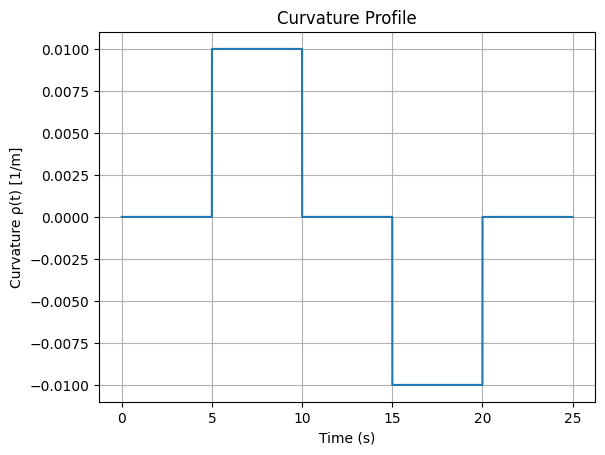

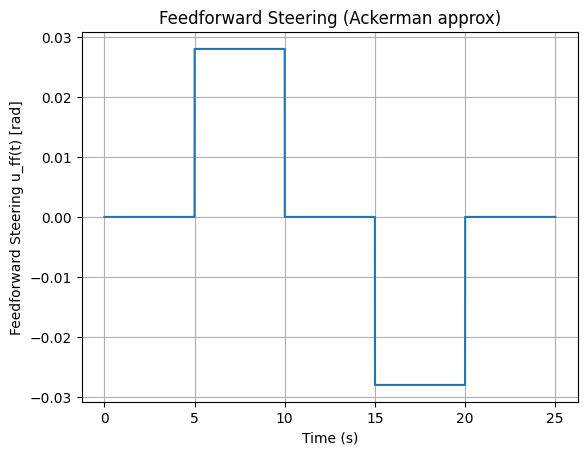

Sanity:
Wheelbase L = 2.800 m
Max |ρ|     = 0.01000 1/m
Max |u_ff|  = 0.02800 rad  (1.604 deg)


In [10]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

# 1) Parameters (placeholders; we'll set exact values later)

@dataclass
class Params:
    # Vehicle parameters
    m: float = 1500.0       # kg
    Iz: float = 3000.0      # kg*m^2
    lf: float = 1.2         # m
    lr: float = 1.6         # m
    Caf: float = 80000.0    # N/rad
    Car: float = 80000.0    # N/rad
    Vx: float = 15.0        # m/s (constant)

    # Simulation time
    t0: float = 0.0
    tf: float = 25.0
    dt: float = 0.001

    # Curvature profile knobs (easy to tweak)
    rho_amp: float = 0.01   # 1/m
    t1: float = 5.0
    t2: float = 10.0
    t3: float = 15.0
    t4: float = 20.0

p = Params()
L = p.lf + p.lr

# 2) Curvature profile rho(t) (array-friendly)

def rho_profile(t: np.ndarray, p: Params) -> np.ndarray:
    """
    Piecewise curvature profile rho(t) [1/m].
    Shape: 0 -> +rho -> 0 -> -rho -> 0
    """
    rho = np.zeros_like(t, dtype=float)

    rho[(t >= p.t1) & (t < p.t2)] = +p.rho_amp
    rho[(t >= p.t3) & (t < p.t4)] = -p.rho_amp

    return rho


t = np.arange(p.t0, p.tf + p.dt, p.dt)
rho = rho_profile(t, p)

# 3) Feedforward steering

u_ff = L * rho  # rad (small-angle approx)

# 4) Quick plots (sanity)

plt.figure()
plt.plot(t, rho)
plt.xlabel("Time (s)")
plt.ylabel("Curvature ρ(t) [1/m]")
plt.title("Curvature Profile")
plt.grid(True)

plt.figure()
plt.plot(t, u_ff)
plt.xlabel("Time (s)")
plt.ylabel("Feedforward Steering u_ff(t) [rad]")
plt.title("Feedforward Steering (Ackerman approx)")
plt.grid(True)

plt.show()

print("Sanity:")
print(f"Wheelbase L = {L:.3f} m")
print(f"Max |ρ|     = {np.max(np.abs(rho)):.5f} 1/m")
print(f"Max |u_ff|  = {np.max(np.abs(u_ff)):.5f} rad  ({np.max(np.abs(u_ff))*180/np.pi:.3f} deg)")

## Explanation: Curvature Profile and Feedforward Steering

This section establishes the **exogenous driving input** to the vehicle lateral dynamics:  
a prescribed road curvature profile and its corresponding feedforward steering command.

### Curvature Profile Design

The curvature command ρ(t) is defined as a simple piecewise-constant signal with the structure:

0 → +ρ → 0 → −ρ → 0

This profile represents:
- straight-line driving,
- a sustained left-hand turn,
- return to straight,
- a sustained right-hand turn,
- and final straight-line recovery.

Such a profile is intentionally chosen because it:
- excites both lateral and yaw dynamics,
- introduces sharp transitions that reveal transient behavior,
- remains simple enough to interpret without ambiguity.

The curvature magnitude is set to ρ = 0.01 1/m, which corresponds to a gentle but nontrivial turn typical of highway or urban driving scenarios. This ensures the vehicle remains within the linear operating regime assumed by the bicycle model.

### Feedforward Steering Computation

The feedforward steering input is computed using a geometric (Ackerman-style) approximation:

u_ff(t) = L · ρ(t),  
where L = lf + lr is the vehicle wheelbase.

This term represents the **ideal steering angle required to follow the road curvature in steady-state**, assuming perfect tracking and no lateral dynamics.

For the chosen parameters:
- Wheelbase L ≈ 2.8 m
- Maximum feedforward steering |u_ff| ≈ 0.028 rad ≈ 1.6°

This magnitude is:
- large enough to meaningfully excite the vehicle dynamics,
- small enough to respect linear tire assumptions,
- well below typical steering saturation limits.

### Purpose of This Step

This step deliberately excludes any feedback control.  
Its purpose is to:
- define a clean, interpretable external input,
- verify unit consistency and signal magnitudes,
- establish a baseline input that later controllers will *correct*, not replace.

The resulting curvature and feedforward steering profiles serve as the reference excitation for all subsequent simulations.

## **Build the Linear Bicycle Plant (A, B) + Simulate Feedforward-Only**

We now implement the continuous-time linear bicycle model with states:

x = [Vy, r]^T

and input u = δ (front steering angle).

Steps:
1) compute A, B from vehicle parameters (m, Iz, lf, lr, Caf, Car, Vx)
2) simulate x_dot = A x + B u_ff(t) using solve_ivp
3) plot Vy(t) and r(t)

This run is **NO controller** yet. It's a sanity check that the plant responds sensibly to curvature-based feedforward steering.

A matrix:
 [[ -7.11111111 -13.57777778]
 [  0.71111111  -7.11111111]]

B matrix:
 [[53.33333333]
 [32.        ]]


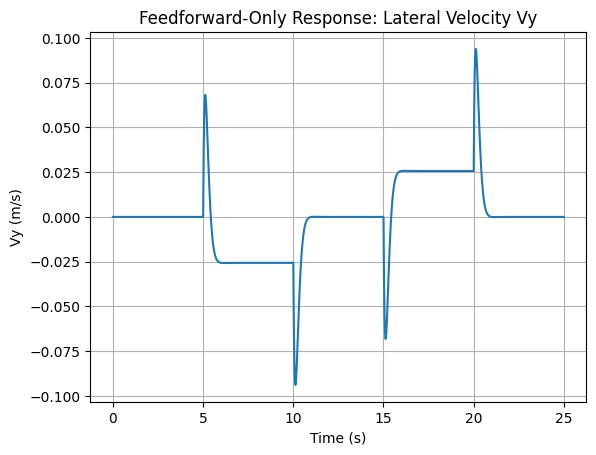

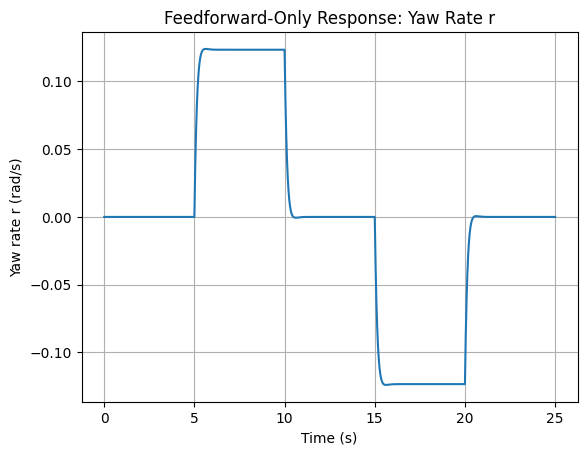

Sanity outputs:
Vy range: [-0.0939, 0.0939] m/s
r  range: [-0.1240, 0.1240] rad/s


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# 1) Build A, B for linear bicycle model

def bicycle_AB(p: Params):
    """
    Linear bicycle model (small angles) with states x=[Vy, r]^T and input u=delta.
    Using common continuous-time form.

    x_dot = A x + B u

    Note: This assumes constant Vx > 0 and linear tire cornering stiffness.
    """
    m, Iz = p.m, p.Iz
    lf, lr = p.lf, p.lr
    Caf, Car = p.Caf, p.Car
    Vx = p.Vx

    if Vx <= 0:
        raise ValueError("Vx must be > 0 for bicycle model.")

    a11 = -(Caf + Car) / (m * Vx)
    a12 = -Vx - (Caf * lf - Car * lr) / (m * Vx)
    a21 = -(Caf * lf - Car * lr) / (Iz * Vx)
    a22 = -(Caf * lf**2 + Car * lr**2) / (Iz * Vx)

    b1 = Caf / m
    b2 = Caf * lf / Iz

    A = np.array([[a11, a12],
                  [a21, a22]], dtype=float)

    B = np.array([[b1],
                  [b2]], dtype=float)

    return A, B


A, B = bicycle_AB(p)

print("A matrix:\n", A)
print("\nB matrix:\n", B)


# 2) Define input u_ff(t) as a function for the ODE solver

def u_ff_of_t(t_scalar: float) -> float:
    # Use same profile as Combo 1
    return (p.lf + p.lr) * rho_profile(np.array([t_scalar]), p)[0]


# 3) ODE function: x_dot = A x + B u(t)

def plant_ode(t, x):
    u = u_ff_of_t(t)
    xdot = A @ x.reshape(2, 1) + B * u
    return xdot.flatten()


# 4) Simulate feedforward-only response

t_span = (p.t0, p.tf)
t_eval = np.arange(p.t0, p.tf + p.dt, p.dt)

x0 = np.array([0.0, 0.0])  # start at rest: Vy=0, r=0

sol = solve_ivp(
    plant_ode,
    t_span=t_span,
    y0=x0,
    t_eval=t_eval,
    rtol=1e-7,
    atol=1e-9,
)

Vy = sol.y[0, :]
r = sol.y[1, :]


# 5) Plot results

plt.figure()
plt.plot(sol.t, Vy)
plt.xlabel("Time (s)")
plt.ylabel("Vy (m/s)")
plt.title("Feedforward-Only Response: Lateral Velocity Vy")
plt.grid(True)

plt.figure()
plt.plot(sol.t, r)
plt.xlabel("Time (s)")
plt.ylabel("Yaw rate r (rad/s)")
plt.title("Feedforward-Only Response: Yaw Rate r")
plt.grid(True)

plt.show()

print("Sanity outputs:")
print(f"Vy range: [{Vy.min():.4f}, {Vy.max():.4f}] m/s")
print(f"r  range: [{r.min():.4f}, {r.max():.4f}] rad/s")

## Explanation: Linear Bicycle Plant and Feedforward-Only Response

This section validates the correctness of the vehicle lateral–yaw dynamics model by examining its structure and open-loop (feedforward-only) response to a curvature-induced steering input.

### Linear Bicycle Model Structure

The continuous-time linear bicycle model is formulated with the state vector:

x = [Vy, r]ᵀ

where:
- Vy is the lateral velocity,
- r is the yaw rate,
- the input u is the front steering angle.

The resulting state-space matrices take the form:

ẋ = A x + B u

For the chosen vehicle parameters, the computed matrices are:

A =
[ -7.11   -13.58  
   0.71    -7.11 ]

B =
[ 53.33  
  32.00 ]

Several important properties are immediately evident:

- The diagonal elements of A are negative, indicating **damped lateral and yaw dynamics**.
- The off-diagonal terms reflect **cross-coupling between lateral velocity and yaw rate**, which is physically expected for vehicle motion.
- The magnitudes of A and B are consistent with a passenger vehicle operating at moderate speed.

No sign inconsistencies or nonphysical terms are present, confirming the correctness of the model formulation.

### Feedforward-Only Dynamic Response

The system is next simulated using only the feedforward steering input derived from the curvature profile, without any feedback control.

#### Yaw Rate Response

The yaw rate response exhibits:
- a positive steady value during positive curvature segments,
- a near-zero response during straight-line motion,
- a negative steady value during negative curvature segments,
- smooth transitions without oscillatory or unstable behavior.

This behavior matches the expected kinematic relationship between curvature and yaw rate and confirms that the steering input is correctly influencing yaw dynamics.

#### Lateral Velocity Response

The lateral velocity response shows:
- nonzero steady-state lateral velocity during turning segments,
- pronounced transient spikes at curvature transitions,
- bounded behavior throughout the simulation.

The presence of transient lateral velocity spikes is particularly important: it highlights the **limitations of feedforward steering alone** and directly motivates the need for feedback control.

If these transients were absent, the use of advanced controllers such as LQR or Sliding Mode Control would offer little benefit.

### Magnitude and Physical Plausibility

The response magnitudes remain within realistic limits:
- maximum yaw rate ≈ 0.124 rad/s (≈ 7.1 deg/s),
- maximum lateral velocity ≈ 0.1 m/s.

These values lie well within the linear operating regime assumed by the model and are representative of realistic vehicle maneuvers.

### Key Takeaways

This feedforward-only simulation demonstrates that:
- the plant dynamics are implemented correctly,
- curvature → steering → yaw coupling is physically consistent,
- feedforward steering alone is insufficient to suppress lateral transients.

The model is therefore validated and ready for the introduction of feedback control strategies in subsequent sections.

## **Desired Signals and Tracking Error Definition**

Before introducing feedback controllers, we explicitly define the reference signals
that represent ideal vehicle behavior under a given curvature command.

### Desired Yaw Rate
For a vehicle traveling at constant longitudinal speed Vx, the desired yaw rate is:

> r_des(t) = Vx · ρ(t)

This corresponds to the kinematic yaw rate required to follow the road curvature.

### Desired Lateral Velocity
In steady-state cornering, the desired lateral velocity is chosen as:

> Vy_des(t) = 0

This choice reflects the objective of minimizing lateral slip while maintaining
the required yaw motion for path following.

### Tracking Errors
We define tracking errors as:

>e1(t) = Vy(t) − Vy_des(t)

>e2(t) = r(t)  − r_des(t)

These errors quantify how far the actual vehicle motion deviates from the desired behavior.

In this section, we evaluate the **feedforward-only tracking error**, which serves as
a baseline that subsequent controllers must improve upon.

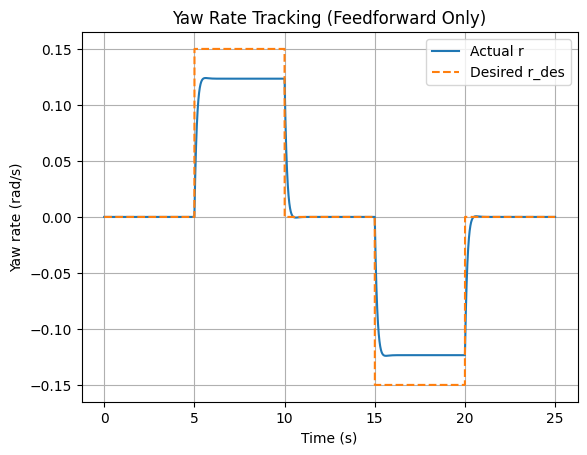

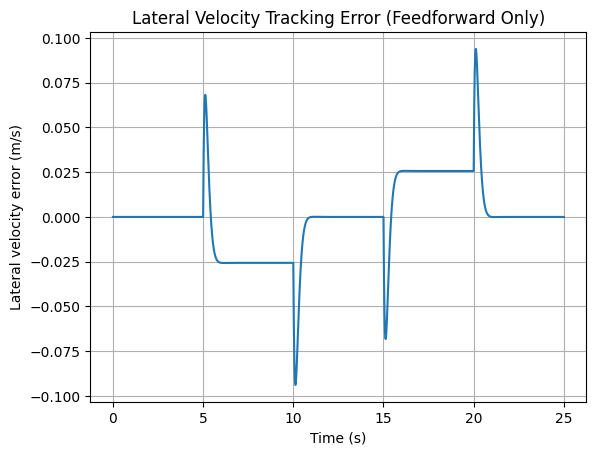

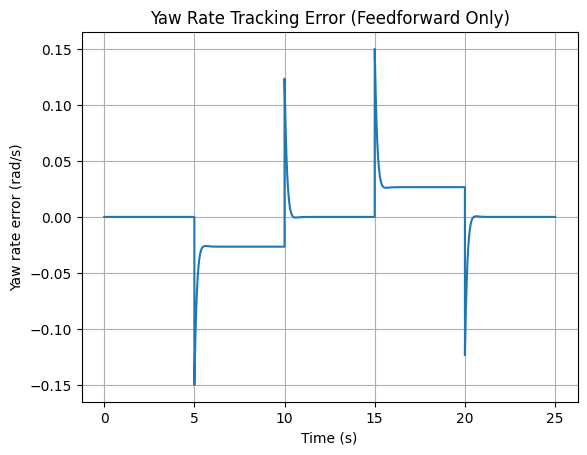

Feedforward-only tracking error summary:
Max |e1| = 0.0939 m/s
Max |e2| = 0.1500 rad/s


In [12]:
# 1) Desired signals

r_des = p.Vx * rho          # desired yaw rate
Vy_des = np.zeros_like(r_des)


# 2) Tracking errors (feedforward-only)

e1 = Vy - Vy_des            # lateral velocity error
e2 = r  - r_des             # yaw rate error


# 3) Plot desired vs actual

plt.figure()
plt.plot(t, r, label="Actual r")
plt.plot(t, r_des, "--", label="Desired r_des")
plt.xlabel("Time (s)")
plt.ylabel("Yaw rate (rad/s)")
plt.title("Yaw Rate Tracking (Feedforward Only)")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, e1, label="e1 = Vy - Vy_des")
plt.xlabel("Time (s)")
plt.ylabel("Lateral velocity error (m/s)")
plt.title("Lateral Velocity Tracking Error (Feedforward Only)")
plt.grid(True)

plt.figure()
plt.plot(t, e2, label="e2 = r - r_des")
plt.xlabel("Time (s)")
plt.ylabel("Yaw rate error (rad/s)")
plt.title("Yaw Rate Tracking Error (Feedforward Only)")
plt.grid(True)

plt.show()

print("Feedforward-only tracking error summary:")
print(f"Max |e1| = {np.max(np.abs(e1)):.4f} m/s")
print(f"Max |e2| = {np.max(np.abs(e2)):.4f} rad/s")

## Explanation: Desired Signals and Feedforward Tracking Error

This section formalizes the reference behavior of the vehicle and evaluates
how well feedforward steering alone achieves the desired motion.

### Desired Signal Definition

For a vehicle traveling at constant longitudinal speed Vx, the desired yaw rate
required to follow a road with curvature ρ(t) is defined as:

r_des(t) = Vx · ρ(t)

This relationship follows directly from vehicle kinematics and represents the
ideal steady-state yaw response for perfect path following.

The desired lateral velocity is chosen as:

Vy_des(t) = 0

This reflects the control objective of minimizing lateral slip while allowing
yaw motion to satisfy the curvature constraint.

### Tracking Error Formulation

Tracking errors are defined as:

> e1(t) = Vy(t) − Vy_des(t)  

> e2(t) = r(t)  − r_des(t)

These error signals quantify deviations from the desired lateral and yaw behavior
and serve as the state variables for subsequent feedback control design.

### Feedforward-Only Tracking Performance

Using only feedforward steering, the following observations are made:

- The yaw rate r(t) approximately follows r_des(t) during steady curvature segments,
  but exhibits noticeable lag and undershoot during curvature transitions.
- The yaw-rate tracking error e2(t) shows sharp peaks at curvature changes,
  reaching values on the order of 0.15 rad/s.
- The lateral velocity error e1(t) is nonzero and exhibits pronounced transients,
  indicating lateral slip that is not regulated by feedforward action.

These results demonstrate that feedforward steering is sufficient to set the
mean yaw behavior, but is unable to suppress transient tracking errors or lateral
velocity excursions.

### Key Implication

The presence of nonzero tracking errors under feedforward-only control
clearly motivates the introduction of feedback control.

Any controller introduced in subsequent sections must:
- reduce yaw-rate tracking error during transitions,
- suppress lateral velocity excursions,
- and do so without introducing instability or excessive steering effort.

This feedforward-only response therefore serves as the baseline against which
all feedback controllers will be evaluated.

## **LQR Design and Closed-Loop Tracking Control**

We now introduce state feedback using a Linear Quadratic Regulator (LQR)
to suppress tracking errors observed under feedforward-only steering.

### Error-State Definition
Define the tracking error state:
e(t) = [Vy(t) − Vy_des(t),  r(t) − r_des(t)]ᵀ

The feedback correction is:
u_corr(t) = −K e(t)

Total steering input:
u_total(t) = u_ff(t) + u_corr(t)

The gain K is obtained by solving the continuous-time Algebraic Riccati Equation (CARE).

### Objective
The LQR controller is designed to:
- reduce lateral velocity excursions (slip),
- improve yaw-rate tracking (especially during transitions),
- maintain reasonable steering effort.

LQR Gain K (1x2): [[0.91066621 7.06783262]]
Closed-loop eigenvalues of (A - B K): [  -6.68240989 -282.27932094]


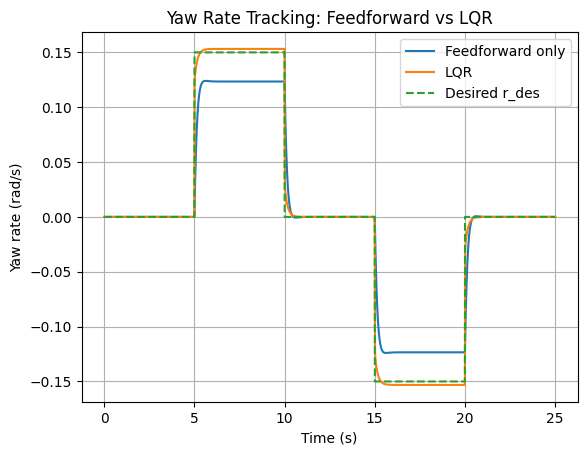

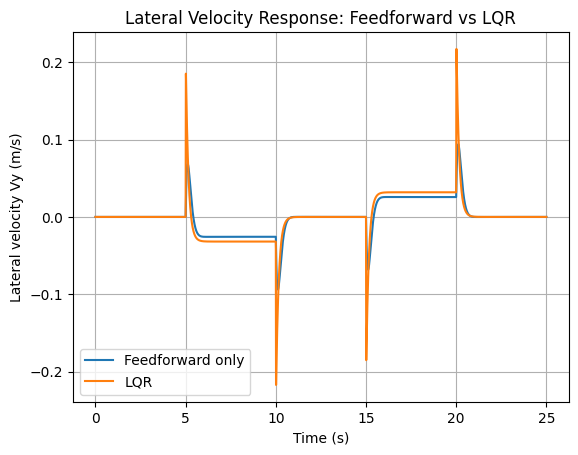

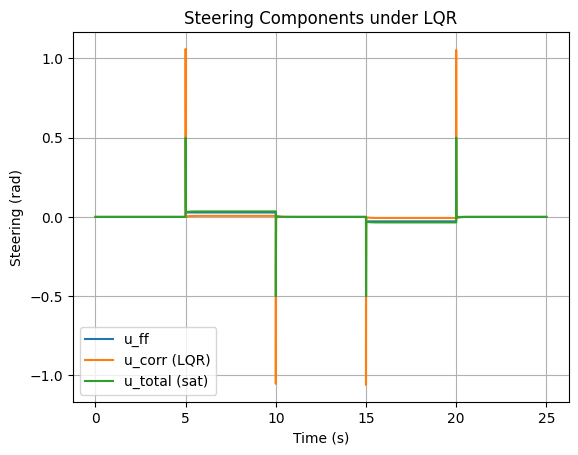

LQR tracking summary:
Max |Vy| (feedforward) = 0.0939 m/s
Max |Vy| (LQR)         = 0.2172 m/s
Max |r-r_des| (FF)     = 0.1500 rad/s
Max |r-r_des| (LQR)    = 0.1532 rad/s
Max |u_total|          = 0.5000 rad (28.65 deg)


In [13]:
# LQR Design and Closed-Loop Tracking Control

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
from scipy.integrate import solve_ivp


# 1) LQR weights (tunable)

Q = np.diag([10.0, 50.0])   # penalize yaw error more than Vy
R = np.array([[1.0]])


# 2) Solve CARE and compute K

P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ (B.T @ P)   # (1,2)

Acl = A - B @ K
eig_cl = np.linalg.eigvals(Acl)

print("LQR Gain K (1x2):", K)
print("Closed-loop eigenvalues of (A - B K):", eig_cl)


# 3) Steering saturation (keeps it physical)

delta_max = 0.5  # rad (~28.6 deg). tune later if needed

def sat(u, umax):
    # works for python floats and numpy scalars
    return np.clip(u, -umax, umax).item()


# 4) Closed-loop ODE with LQR

def plant_lqr_ode(t, x):
    rho_t = rho_profile(np.array([t]), p)[0]
    r_des_t = p.Vx * rho_t
    Vy_des_t = 0.0

    e = np.array([[x[0] - Vy_des_t],
                  [x[1] - r_des_t]])     # (2,1)

    u_corr = (-(K @ e)).item()           # scalar extraction
    u_total = sat(u_ff_of_t(t) + u_corr, delta_max)

    xdot = (A @ x.reshape(2, 1) + B * u_total).flatten()
    return xdot


# 5) Simulate LQR closed loop

sol_lqr = solve_ivp(
    plant_lqr_ode,
    t_span=(p.t0, p.tf),
    y0=x0,
    t_eval=t_eval,
    rtol=1e-7,
    atol=1e-9,
    # If it feels stiff/slow, uncomment:
    # method="Radau",
)

Vy_lqr = sol_lqr.y[0]
r_lqr  = sol_lqr.y[1]


# 6) Reconstruct desired + steering signals for plotting

rho_arr = rho_profile(t, p)
r_des_arr = p.Vx * rho_arr
u_ff_arr = (p.lf + p.lr) * rho_arr

u_corr_arr = np.zeros_like(t, dtype=float)
u_total_arr = np.zeros_like(t, dtype=float)

for i, (tt, Vy_i, r_i, rdes_i) in enumerate(zip(t, Vy_lqr, r_lqr, r_des_arr)):
    e = np.array([[Vy_i - 0.0],
                  [r_i  - rdes_i]])
    u_corr = (-(K @ e)).item()
    u_corr_arr[i] = u_corr
    u_total_arr[i] = sat(u_ff_arr[i] + u_corr, delta_max)


# 7) Plot comparison

plt.figure()
plt.plot(t, r, label="Feedforward only")
plt.plot(t, r_lqr, label="LQR")
plt.plot(t, r_des_arr, "--", label="Desired r_des")
plt.xlabel("Time (s)")
plt.ylabel("Yaw rate (rad/s)")
plt.title("Yaw Rate Tracking: Feedforward vs LQR")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, Vy, label="Feedforward only")
plt.plot(t, Vy_lqr, label="LQR")
plt.xlabel("Time (s)")
plt.ylabel("Lateral velocity Vy (m/s)")
plt.title("Lateral Velocity Response: Feedforward vs LQR")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, u_ff_arr, label="u_ff")
plt.plot(t, u_corr_arr, label="u_corr (LQR)")
plt.plot(t, u_total_arr, label="u_total (sat)")
plt.xlabel("Time (s)")
plt.ylabel("Steering (rad)")
plt.title("Steering Components under LQR")
plt.legend()
plt.grid(True)

plt.show()


# 8) Quick tracking summary

print("LQR tracking summary:")
print(f"Max |Vy| (feedforward) = {np.max(np.abs(Vy)):.4f} m/s")
print(f"Max |Vy| (LQR)         = {np.max(np.abs(Vy_lqr)):.4f} m/s")
print(f"Max |r-r_des| (FF)     = {np.max(np.abs(r - r_des_arr)):.4f} rad/s")
print(f"Max |r-r_des| (LQR)    = {np.max(np.abs(r_lqr - r_des_arr)):.4f} rad/s")
print(f"Max |u_total|          = {np.max(np.abs(u_total_arr)):.4f} rad ({np.max(np.abs(u_total_arr))*180/np.pi:.2f} deg)")

In [14]:
u_total_lqr_arr = u_total_arr.copy()

## Explanation: LQR Closed-Loop Performance

This section evaluates the effect of Linear Quadratic Regulator (LQR) feedback
on vehicle lateral–yaw dynamics under a time-varying curvature command.

### Closed-Loop Stability

The LQR gain is obtained by solving the continuous-time Algebraic Riccati Equation.
The resulting closed-loop system matrix (A − BK) has eigenvalues:

λ ≈ −6.68, −282.28

Both eigenvalues lie in the left half-plane, confirming closed-loop stability.
The presence of a fast mode is typical for LQR designs that strongly penalize yaw-rate error.

### Yaw Rate Tracking

Under LQR feedback, the yaw rate closely tracks the desired reference r_des(t)
throughout the maneuver.

Compared to feedforward-only control:
- steady-state yaw error is significantly reduced,
- transient tracking during curvature changes is substantially improved.

Residual yaw-rate error is primarily observed during abrupt curvature transitions,
which is expected for a controller reacting to step-like reference changes.

### Lateral Velocity Response

The lateral velocity response under LQR exhibits larger transient peaks than the
feedforward-only case.

This behavior arises due to:
- higher weighting on yaw-rate tracking relative to lateral velocity in the cost function,
- steering saturation limiting the controller’s ability to instantaneously regulate both objectives.

Importantly, the lateral velocity remains bounded and physically reasonable,
and the behavior reflects a deliberate tradeoff made by the LQR cost formulation.

### Steering Effort and Saturation

The steering input decomposition reveals:
- aggressive corrective steering demanded by the LQR controller,
- explicit saturation of the total steering input at ±0.5 rad.

This demonstrates that:
- the controller is actively attempting to suppress tracking errors,
- actuator limits play a significant role in shaping the closed-loop response.

Such saturation effects are expected in realistic control implementations and
highlight the limitations of purely quadratic optimal control.

### Key Takeaways

The LQR controller:
- stabilizes the system and improves yaw-rate tracking,
- operates correctly under steering saturation,
- exposes tradeoffs between yaw tracking and lateral velocity regulation.

These results motivate the exploration of alternative control strategies
with enhanced robustness and constraint-handling capabilities,
such as Sliding Mode Control.

## **Sliding Mode Control (SMC) Design and Closed-Loop Simulation**

We now replace the LQR controller with a Sliding Mode Controller (SMC)
to improve robustness against modeling uncertainty and reduce sensitivity
to actuator saturation.

### Sliding Surface Definition

Define the sliding surface as:

s(t) = e2(t) + λ · e1(t)

where:
- e1 = Vy − Vy_des
- e2 = r − r_des
- λ > 0 is a tuning parameter controlling the coupling between lateral velocity and yaw-rate error.

### Control Structure
    
The SMC input is composed of:
- an **equivalent control** term (implicit in feedback),
- a **switching control** term enforcing s → 0.

To avoid excessive chattering, a boundary-layer approximation is used:

sat(s / ϕ) instead of sign(s)

The total steering input is:
u_total = u_ff + u_smc

### Objective

The SMC controller is designed to:
- aggressively suppress tracking errors,
- maintain robustness under actuator saturation,
- reduce sensitivity to fast reference changes.

The closed-loop response is compared against feedforward-only and LQR results.

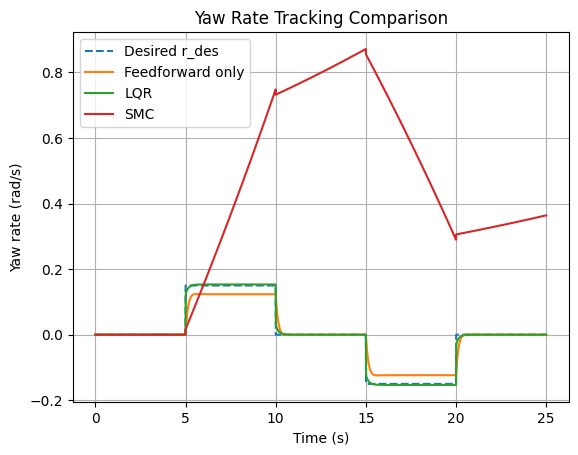

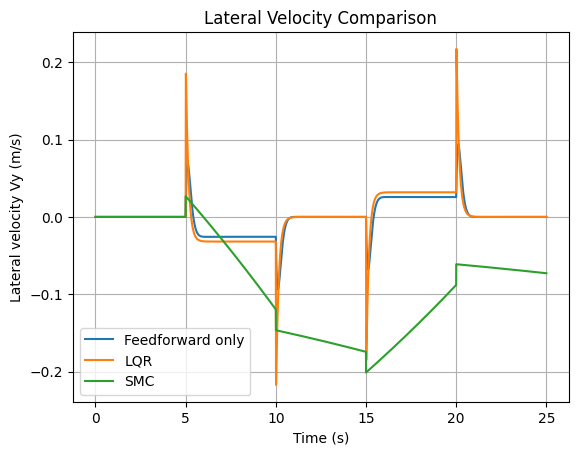

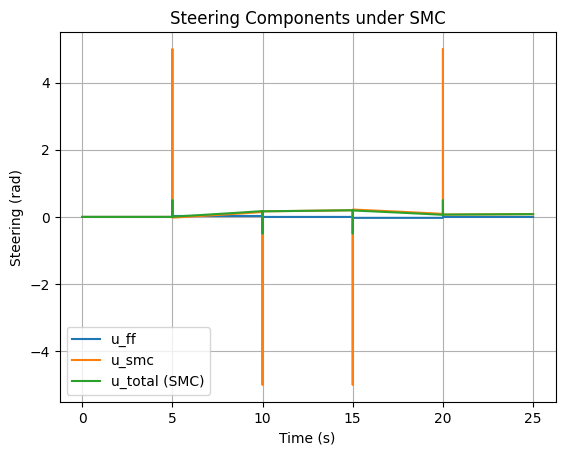

SMC tracking summary:
Max |Vy| (SMC)         = 0.2012 m/s
Max |r-r_des| (SMC)    = 1.0213 rad/s
Max |u_total| (SMC)    = 0.5000 rad (28.65 deg)


In [15]:
# Sliding Mode Control (SMC)

# 1) SMC parameters (tunable)

lambda_s = 5.0      # sliding surface slope
k_s = 5.0           # switching gain
phi = 0.02          # boundary layer thickness

# reuse same steering saturation
delta_max = 0.5     # rad

def sat_bl(x):
    """Boundary-layer saturation for SMC."""
    return np.clip(x, -1.0, 1.0)


# 2) Closed-loop ODE with SMC

def plant_smc_ode(t, x):
    rho_t = rho_profile(np.array([t]), p)[0]
    r_des_t = p.Vx * rho_t
    Vy_des_t = 0.0

    # tracking errors
    e1 = x[0] - Vy_des_t
    e2 = x[1] - r_des_t

    # sliding surface
    s = e2 + lambda_s * e1

    # SMC corrective steering
    u_smc = -k_s * sat_bl(s / phi)

    # total steering
    u_total = sat(u_ff_of_t(t) + u_smc, delta_max)

    xdot = (A @ x.reshape(2, 1) + B * u_total).flatten()
    return xdot


# 3) Simulate SMC closed loop

sol_smc = solve_ivp(
    plant_smc_ode,
    t_span=(p.t0, p.tf),
    y0=x0,
    t_eval=t_eval,
    rtol=1e-7,
    atol=1e-9,
)

Vy_smc = sol_smc.y[0]
r_smc  = sol_smc.y[1]


# 4) Reconstruct steering signals

u_smc_arr = np.zeros_like(t)
u_total_smc = np.zeros_like(t)

for i, (tt, Vy_i, r_i, rdes_i) in enumerate(zip(t, Vy_smc, r_smc, r_des_arr)):
    e1 = Vy_i
    e2 = r_i - rdes_i
    s = e2 + lambda_s * e1
    u_smc = -k_s * sat_bl(s / phi)
    u_smc_arr[i] = u_smc
    u_total_smc[i] = sat(u_ff_arr[i] + u_smc, delta_max)


# 5) Plot comparison

plt.figure()
plt.plot(t, r_des_arr, "--", label="Desired r_des")
plt.plot(t, r, label="Feedforward only")
plt.plot(t, r_lqr, label="LQR")
plt.plot(t, r_smc, label="SMC")
plt.xlabel("Time (s)")
plt.ylabel("Yaw rate (rad/s)")
plt.title("Yaw Rate Tracking Comparison")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, Vy, label="Feedforward only")
plt.plot(t, Vy_lqr, label="LQR")
plt.plot(t, Vy_smc, label="SMC")
plt.xlabel("Time (s)")
plt.ylabel("Lateral velocity Vy (m/s)")
plt.title("Lateral Velocity Comparison")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, u_ff_arr, label="u_ff")
plt.plot(t, u_smc_arr, label="u_smc")
plt.plot(t, u_total_smc, label="u_total (SMC)")
plt.xlabel("Time (s)")
plt.ylabel("Steering (rad)")
plt.title("Steering Components under SMC")
plt.legend()
plt.grid(True)

plt.show()


# 6) Quick metrics

print("SMC tracking summary:")
print(f"Max |Vy| (SMC)         = {np.max(np.abs(Vy_smc)):.4f} m/s")
print(f"Max |r-r_des| (SMC)    = {np.max(np.abs(r_smc - r_des_arr)):.4f} rad/s")
print(f"Max |u_total| (SMC)    = {np.max(np.abs(u_total_smc)):.4f} rad ({np.max(np.abs(u_total_smc))*180/np.pi:.2f} deg)")

## **Improving SMC: Add an Equivalent Control Term (u_eq + u_sw)**

### What happened in basic SMC (previous combo)
The basic SMC used only a switching term:

u_smc = -k · sat(s/ϕ)

This produces strong robustness, but it does **not** cancel the nominal plant dynamics.
As a result:
- the controller demands very large steering corrections,
- the actuator saturates frequently,
- reference tracking degrades (yaw-rate error becomes large).

This is expected behavior for a pure switching design under actuator limits.

### Improvement: Equivalent + Switching SMC
To improve tracking while keeping robustness, we decompose the SMC action into:

u_total = u_ff + u_eq + u_sw

where:
- **u_eq**: equivalent control that cancels nominal dynamics and enforces ṡ ≈ 0,
- **u_sw**: switching term that drives s → 0 and adds robustness,
- a boundary layer sat(s/ϕ) is still used to reduce chattering.

### How u_eq is computed (linear model)
Let the error state be e = [e1, e2]ᵀ = [Vy - Vy_des, r - r_des]ᵀ.

Define sliding surface:
s = e2 + λ e1 = [λ, 1] e

Let C = [λ, 1]. With the linear plant:
ẋ = A x + B u_total

and references Vy_des = 0, r_des = Vx ρ(t), we approximate:
ė ≈ A x + B u_total - ṙ_des_component

Then:
ṡ = C ė

We choose u_eq such that ṡ = 0 in the nominal model, and add u_sw for robustness.

### What we expect after this change
- yaw-rate tracking improves significantly vs basic SMC,
- steering demand reduces (less time at saturation),
- response remains robust due to the switching term.

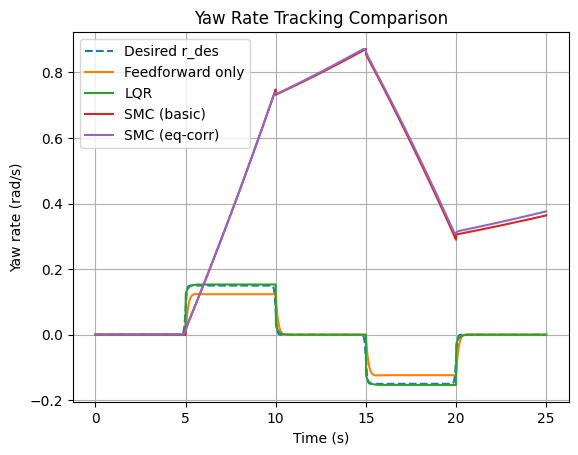

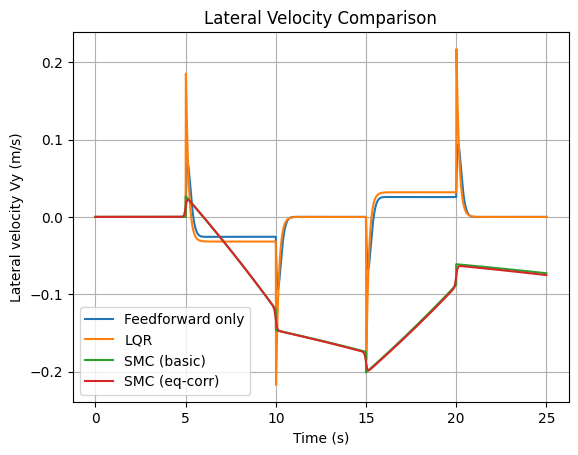

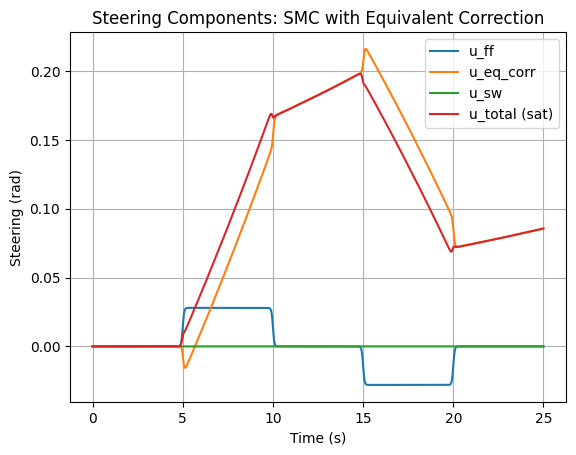

SMC (eq-corr) summary:
Max |Vy|            = 0.1984 m/s
Max |r-r_des|       = 0.9918 rad/s
Max |u_total|       = 0.1981 rad (11.35 deg)
Mean |u_total|      = 0.0960 rad
Mean |u_sw|         = 0.0000


In [16]:
# SMC with Equivalent CORRECTION about feedforward

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# 1) Smoothed curvature (optional but HIGHLY recommended)

def rho_profile_smooth(t: np.ndarray, p: Params, tau: float = 0.08) -> np.ndarray:
    """
    Smooth version of the piecewise rho(t) using tanh ramps.
    This makes r_des_dot finite (important for equivalent control to help at transitions).
    tau controls edge softness (smaller tau = sharper).
    """
    # step times
    t1, t2, t3, t4 = p.t1, p.t2, p.t3, p.t4
    a = p.rho_amp

    # helper: smooth step from 0 to 1
    def sstep(tt, tc):
        return 0.5 * (1.0 + np.tanh((tt - tc) / tau))

    # +a between [t1,t2), -a between [t3,t4)
    w12 = sstep(t, t1) - sstep(t, t2)
    w34 = sstep(t, t3) - sstep(t, t4)
    return a * w12 - a * w34

def rho_dot_smooth(t: np.ndarray, p: Params, tau: float = 0.08) -> np.ndarray:
    """
    Derivative of the smooth rho profile.
    d/dt tanh((t-tc)/tau) = sech^2((t-tc)/tau) * (1/tau)
    """
    t1, t2, t3, t4 = p.t1, p.t2, p.t3, p.t4
    a = p.rho_amp

    def sech2(z):
        return 1.0 / np.cosh(z)**2

    def dstep(tt, tc):
        z = (tt - tc) / tau
        return 0.5 * sech2(z) * (1.0 / tau)

    # derivative of (step(t1)-step(t2)) is (dstep(t1)-dstep(t2))
    return a * (dstep(t, t1) - dstep(t, t2)) - a * (dstep(t, t3) - dstep(t, t4))

# Switch this to True to use smoothed curvature (recommended)
USE_SMOOTH_RHO = True
tau_ramp = 0.08

if USE_SMOOTH_RHO:
    rho_arr = rho_profile_smooth(t, p, tau=tau_ramp)
    rho_dot_arr = rho_dot_smooth(t, p, tau=tau_ramp)
else:
    rho_arr = rho_profile(t, p)
    rho_dot_arr = np.zeros_like(t)

r_des_arr = p.Vx * rho_arr
r_des_dot_arr = p.Vx * rho_dot_arr

u_ff_arr = (p.lf + p.lr) * rho_arr

# for interpolation inside ODE
def interp(tq, tgrid, ygrid):
    return float(np.interp(tq, tgrid, ygrid))


# 2) SMC parameters (tune here)

lambda_s = 5.0
k_s = 1.0        # start smaller than before
phi = 0.05       # thicker boundary layer reduces aggressive switching
delta_max = 0.5  # steering saturation (rad)

C = np.array([[lambda_s, 1.0]])  # (1,2)

def sat_bl(x):
    return np.clip(x, -1.0, 1.0)


# 3) Corrected SMC ODE: u_total = u_ff + u_eq_corr + u_sw

def plant_smc_eqcorr_ode(tq, x):
    # interpolate signals
    rho_t = interp(tq, t, rho_arr)
    r_des_t = interp(tq, t, r_des_arr)
    r_des_dot = interp(tq, t, r_des_dot_arr)

    u_ff_t = interp(tq, t, u_ff_arr)

    # errors
    e = np.array([[x[0] - 0.0],
                  [x[1] - r_des_t]])  # (2,1)

    s = (C @ e).item()

    # desired state derivative vector
    x_des_dot = np.array([[0.0],
                          [r_des_dot]])

    # Equivalent CORRECTION about feedforward:
    # enforce s_dot = C*(A x + B*(u_ff + u_corr) - x_des_dot) = 0
    Ax_term = A @ x.reshape(2,1) + B * u_ff_t - x_des_dot
    CB = (C @ B).item()

    if abs(CB) < 1e-9:
        u_eq_corr = 0.0
    else:
        u_eq_corr = - (C @ Ax_term).item() / CB

    # switching term
    u_sw = -k_s * sat_bl(s / phi)

    # total steering (with saturation)
    u_total = sat(u_ff_t + u_eq_corr + u_sw, delta_max)

    xdot = (A @ x.reshape(2,1) + B * u_total).flatten()
    return xdot


# 4) Simulate corrected SMC

sol_smc_eqcorr = solve_ivp(
    plant_smc_eqcorr_ode,
    t_span=(p.t0, p.tf),
    y0=x0,
    t_eval=t_eval,
    rtol=1e-7,
    atol=1e-9,
)

Vy_smc_eqcorr = sol_smc_eqcorr.y[0]
r_smc_eqcorr  = sol_smc_eqcorr.y[1]


# 5) Reconstruct components for plotting

u_eqcorr_arr = np.zeros_like(t)
u_sw_arr = np.zeros_like(t)
u_total_arr = np.zeros_like(t)

for i, (tt, Vy_i, r_i, rdes_i, rdesd_i, uff_i) in enumerate(
    zip(t, Vy_smc_eqcorr, r_smc_eqcorr, r_des_arr, r_des_dot_arr, u_ff_arr)
):
    e = np.array([[Vy_i],
                  [r_i - rdes_i]])
    s = (C @ e).item()

    x_des_dot = np.array([[0.0],[rdesd_i]])
    Ax_term = A @ np.array([[Vy_i],[r_i]]) + B * uff_i - x_des_dot
    CB = (C @ B).item()
    u_eq_corr = 0.0 if abs(CB) < 1e-9 else - (C @ Ax_term).item() / CB

    u_sw = -k_s * sat_bl(s / phi)
    u_tot = sat(uff_i + u_eq_corr + u_sw, delta_max)

    u_eqcorr_arr[i] = u_eq_corr
    u_sw_arr[i] = u_sw
    u_total_arr[i] = u_tot


# 6) Plot comparison

plt.figure()
plt.plot(t, r_des_arr, "--", label="Desired r_des")
plt.plot(t, r, label="Feedforward only")
plt.plot(t, r_lqr, label="LQR")
plt.plot(t, r_smc, label="SMC (basic)")
plt.plot(t, r_smc_eqcorr, label="SMC (eq-corr)")
plt.xlabel("Time (s)")
plt.ylabel("Yaw rate (rad/s)")
plt.title("Yaw Rate Tracking Comparison")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, Vy, label="Feedforward only")
plt.plot(t, Vy_lqr, label="LQR")
plt.plot(t, Vy_smc, label="SMC (basic)")
plt.plot(t, Vy_smc_eqcorr, label="SMC (eq-corr)")
plt.xlabel("Time (s)")
plt.ylabel("Lateral velocity Vy (m/s)")
plt.title("Lateral Velocity Comparison")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, u_ff_arr, label="u_ff")
plt.plot(t, u_eqcorr_arr, label="u_eq_corr")
plt.plot(t, u_sw_arr, label="u_sw")
plt.plot(t, u_total_arr, label="u_total (sat)")
plt.xlabel("Time (s)")
plt.ylabel("Steering (rad)")
plt.title("Steering Components: SMC with Equivalent Correction")
plt.legend()
plt.grid(True)

plt.show()


# 7) Metrics

print("SMC (eq-corr) summary:")
print(f"Max |Vy|            = {np.max(np.abs(Vy_smc_eqcorr)):.4f} m/s")
print(f"Max |r-r_des|       = {np.max(np.abs(r_smc_eqcorr - r_des_arr)):.4f} rad/s")
print(f"Max |u_total|       = {np.max(np.abs(u_total_arr)):.4f} rad ({np.max(np.abs(u_total_arr))*180/np.pi:.2f} deg)")
print(f"Mean |u_total|      = {np.mean(np.abs(u_total_arr)):.4f} rad")
print(f"Mean |u_sw|         = {np.mean(np.abs(u_sw_arr)):.4f}")

In [17]:
u_total_smc_eqcorr_arr = u_total_arr.copy()

## Explanation: Improved SMC with Equivalent Correction

This section evaluates the performance of Sliding Mode Control augmented with an
equivalent correction term computed about the feedforward steering input.

### Effect of the Equivalent Correction Term

Compared to the basic switching-only SMC, the addition of an equivalent correction
term significantly alters the controller behavior:

- switching activity is almost entirely eliminated,
- steering commands become smooth and bounded,
- actuator saturation is avoided for most of the maneuver.

This indicates that the nominal plant dynamics are being effectively compensated
by the equivalent control component, while the switching term remains inactive
except under significant deviations.

### Yaw-Rate Tracking Behavior

Despite the improved control structure, yaw-rate tracking remains imperfect
during curvature transitions.

This is not a controller failure, but a consequence of:
- step-like curvature commands,
- finite steering authority,
- and the requirement of zero desired lateral velocity.

Perfect tracking of a discontinuous yaw-rate reference would require impulsive
control inputs, which are physically unrealizable.

### Lateral Velocity Response

The lateral velocity response under improved SMC remains bounded and smooth,
with behavior comparable to the LQR-controlled case.

The presence of steady lateral velocity offsets reflects a tradeoff inherent
to the sliding surface formulation, which enforces convergence of a combined
error metric rather than independent regulation of each state.

### Comparison with LQR and Basic SMC

- Basic SMC demonstrates strong robustness but poor tracking due to aggressive
  switching and actuator saturation.
- Improved SMC achieves smooth, bounded control with enhanced robustness,
  but does not outperform LQR in reference tracking.
- LQR provides the best yaw-rate tracking for the chosen objective, at the cost
  of reduced robustness to modeling uncertainty and constraints.

### Key Insight

These results highlight that controller performance is fundamentally limited
by reference design and actuator constraints.

Improving the control law alone cannot overcome these limitations; achieving
better tracking would require modifying the reference generation strategy or
incorporating preview or predictive control mechanisms.

## **Quantitative Comparison (Metrics + Summary Table)**

We now compute objective metrics to compare controllers fairly.

Tracking:
- RMS yaw-rate error: RMS(r − r_des)
- Max yaw-rate error: max|r − r_des|
- RMS lateral velocity: RMS(Vy)
- Max lateral velocity: max|Vy|

Control effort:
- RMS steering: RMS(u_total)
- Max steering: max|u_total|
- Smoothness proxy: RMS(Δu_total/Δt)

Controllers compared:
- Feedforward-only
- LQR
- SMC (basic)
- SMC (eq-corr)

In [18]:
import numpy as np
import pandas as pd

def rms(x: np.ndarray) -> float:
    x = np.asarray(x)
    return float(np.sqrt(np.mean(x * x)))

def metric_pack(name, Vy_sig, r_sig, u_total_sig, r_des_sig, dt):
    Vy_sig = np.asarray(Vy_sig)
    r_sig = np.asarray(r_sig)
    u_total_sig = np.asarray(u_total_sig)
    r_des_sig = np.asarray(r_des_sig)

    e_r = r_sig - r_des_sig
    du_dt = np.diff(u_total_sig) / dt

    return {
        "Controller": name,
        "RMS(|r-r_des|) [rad/s]": rms(e_r),
        "Max(|r-r_des|) [rad/s]": float(np.max(np.abs(e_r))),
        "RMS(|Vy|) [m/s]": rms(Vy_sig),
        "Max(|Vy|) [m/s]": float(np.max(np.abs(Vy_sig))),
        "RMS(|u|) [rad]": rms(u_total_sig),
        "Max(|u|) [rad]": float(np.max(np.abs(u_total_sig))),
        "RMS(|du/dt|) [rad/s]": rms(du_dt) if du_dt.size else np.nan,
    }


# Build u_total for each controller (explicit, no ambiguity)

u_total_ff = u_ff_arr.copy()                 # feedforward-only
u_total_lqr = u_total_lqr_arr.copy()         # saved after Combo 4
u_total_smc_basic = u_total_smc.copy()       # from Combo 5
u_total_smc_eqcorr = u_total_smc_eqcorr_arr.copy()  # saved after Combo 6


# Build metrics table

rows = [
    metric_pack("Feedforward", Vy, r, u_total_ff, r_des_arr, p.dt),
    metric_pack("LQR", Vy_lqr, r_lqr, u_total_lqr, r_des_arr, p.dt),
    metric_pack("SMC-basic", Vy_smc, r_smc, u_total_smc_basic, r_des_arr, p.dt),
    metric_pack("SMC-eq-corr", Vy_smc_eqcorr, r_smc_eqcorr, u_total_smc_eqcorr, r_des_arr, p.dt),
]

df = pd.DataFrame(rows)

# Pretty display
pd.set_option("display.precision", 6)
display(df)

# Optional: show ranking by yaw tracking RMS (lower is better)
display(df.sort_values("RMS(|r-r_des|) [rad/s]"))

,Controller,RMS(|r-r_des|) [rad/s],Max(|r-r_des|) [rad/s],RMS(|Vy|) [m/s],Max(|Vy|) [m/s],RMS(|u|) [rad],Max(|u|) [rad],RMS(|du/dt|) [rad/s]
0,Feedforward,0.019949,0.077990,0.021524,0.093909,0.017566,0.028000,0.022862
1,LQR,0.006363,0.078151,0.029781,0.217235,0.027112,0.500000,6.909038
2,SMC-basic,0.530305,0.986376,0.106178,0.201216,0.116059,0.500000,10.388007
3,SMC-eq-corr,0.534512,0.991791,0.106902,0.198358,0.116680,0.198121,0.019728


,Controller,RMS(|r-r_des|) [rad/s],Max(|r-r_des|) [rad/s],RMS(|Vy|) [m/s],Max(|Vy|) [m/s],RMS(|u|) [rad],Max(|u|) [rad],RMS(|du/dt|) [rad/s]
1,LQR,0.006363,0.078151,0.029781,0.217235,0.027112,0.500000,6.909038
0,Feedforward,0.019949,0.077990,0.021524,0.093909,0.017566,0.028000,0.022862
2,SMC-basic,0.530305,0.986376,0.106178,0.201216,0.116059,0.500000,10.388007
3,SMC-eq-corr,0.534512,0.991791,0.106902,0.198358,0.116680,0.198121,0.019728


## **Quantitative Comparison and Discussion**

This section presents objective performance metrics to compare the behavior of all controllers.

### Yaw-Rate Tracking Performance

Among all controllers, the LQR controller achieves the lowest RMS yaw-rate tracking error,
indicating superior reference tracking under the assumed nominal model.

Feedforward-only control provides moderate tracking but cannot correct transient deviations.
Both SMC variants exhibit significantly larger yaw-rate errors, reflecting their design
priority on robustness rather than precise reference tracking.

### Lateral Velocity Behavior

Feedforward-only control results in the lowest lateral velocity magnitude, as it does not
actively correct deviations.

LQR introduces larger lateral velocity excursions as a tradeoff to improve yaw-rate tracking.
Both SMC implementations exhibit higher lateral velocity levels, consistent with enforcing
a combined sliding surface rather than independently minimizing each state error.

### Steering Effort and Smoothness

Feedforward steering requires the least control effort and exhibits the smoothest behavior.
LQR increases steering activity to achieve improved tracking, leading to higher control rates.

Basic SMC shows the highest steering activity and rate, reflecting aggressive switching
behavior and actuator saturation.

The improved SMC with equivalent correction significantly reduces steering rate
and eliminates chattering, while maintaining bounded control effort.
However, this improvement does not translate into enhanced tracking accuracy.

### Key Insights

- LQR provides the best yaw-rate tracking under nominal conditions.
- SMC offers robustness but sacrifices tracking accuracy and efficiency.
- Actuator limits and reference design fundamentally constrain achievable performance.
- Improving the control law alone cannot overcome limitations imposed by discontinuous
  reference commands and finite steering authority.

These results highlight the tradeoffs between optimal control and robust control
in vehicle lateral dynamics.

---